# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>1. Import Library</b></div>

<div style="border-radius:10px; border: #FFA500 solid; padding: 15px; font-size:100%;">

📌 **Experimental Parameters**
    
- `Image Size`: 256X256

- `Segmentation`: lung and heart and cropping
    
- `Label Unique`: Label Unique>=2 & No Finding 삭제 
    
- `CLAHE(Contrast Limited Adaptive Histogram Equalization)`: clipLimit: 2.0, tileGridSize: (8,8) 

- `Label Smoothing`: 0.05
    
- `Loss`: BinaryCrossentropy
    
- `Fold`: SKF(n_splits=5) But, Only Traininig Fold1
    
- `Weak Augment`: HFlip, Rotate(limit=5)
    
- `Strong Augment`: CutMix(patch=2), Cutmix size maximum: 256//5
  
- `BackBone Model`: TF EfficientNetB0 Noisy Student
    
- `Freezing Layer`: None
    
- `Batch Size`: 32
    
- `Learning Rate`: 1e-3
    
- `Epoch`: 10
    
- `Optimizer`: Adam

- `Test Time Augmentation`: HFlip, Rotate 

In [1]:
!pip install -q tensorflow==2.15.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.9.1 requires tensorflow~=2.16.1, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-serving-api 2.16.1 requires tensorflow<3,>=2.16.1, but you have tensorflow 2.15.0 which is incompatible.
tensorflow-text 2.16.1 requires tensorflow<2.17,>=2.16.1; platform_machine != "arm64" or platform_system != "Darwin", but you have tensorflow 2.15.0 which is incompatible.
tensorstore 0.1.66 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.16.0 requires tensorflow<2.17,>=2.16, but you have tensorflow 2.15.0 which is incompatible.


In [2]:
import os
import sys
import gc 
import random
import ctypes
from tqdm import tqdm
from collections import defaultdict

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import cv2
from PIL import Image
import albumentations as albu

from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, StratifiedGroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score

import warnings 
warnings.filterwarnings('ignore')


## tensorflow version
import tensorflow as tf
from tensorflow.keras import layers, Model, losses, optimizers
import tensorflow.keras.backend as K

print('tensorflow version: ', tf.__version__)
os.environ['CUDA_IS_VISIBLE'] = '0,1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

gpus = tf.config.list_physical_devices('GPU')
if len(gpus) <=1:
    strategy = tf.distribute.OneDeviceStrategy(device='/gpu:0')
    print(f'Using {len(gpus)} GPUs')
else: 
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')
    
LOAD_MODELS_FROM = None

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2024-10-19 01:48:51.602490: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-19 01:48:51.602554: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 01:48:51.603922: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tensorflow version:  2.15.0
Using 2 GPUs


In [3]:
def clean_memory():
    # malloc_trim: 현재 사용되지 않는 메모리를 시스템에서 다시 반환함0
    ctypes.CDLL('libc.so.6').malloc_trim(0)
    gc.collect()
clean_memory()

In [4]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
seed_everything(42)

In [5]:
MIX = True
if MIX: 
    tf.config.optimizer.set_experimental_options({'auto_mixed_precision':True})
    print('Mixed Precision enabled')
else: 
    print('Using full precision')

Mixed Precision enabled


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>2. Road and Read Data</b></div>

In [6]:
df_pc = pd.read_csv('/kaggle/input/pc-dataset/metadata.csv')
tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', 'pc-dataset','*','*', '*'))}    
    
df_pc['path'] = df_pc['Image Index'].map(tmp)
df_pc['Patient ID'] = 'pc_' + df_pc['Patient ID']
df_pc = df_pc[df_pc['Patient Age'] >= 16].reset_index(drop=True)

In [7]:
df_nih = pd.read_csv('/kaggle/input/nih-big-dataset/metadata.csv')
tmp = {os.path.basename(x): x for x in glob(os.path.join('/kaggle', 'input', 'nih-big-dataset','*','*'))}    
    
df_nih['path'] = df_nih['Image Index'].map(tmp)
    
df_nih['Patient ID'] = df_nih['Patient ID'].astype('string')
df_nih['Patient ID'] = 'nih_' + df_nih['Patient ID'] 
df_nih = df_nih[df_nih['Patient Age'] >= 16].reset_index(drop=True)

In [8]:
df = pd.concat([df_nih, df_pc])
df = df.reset_index(drop=True)

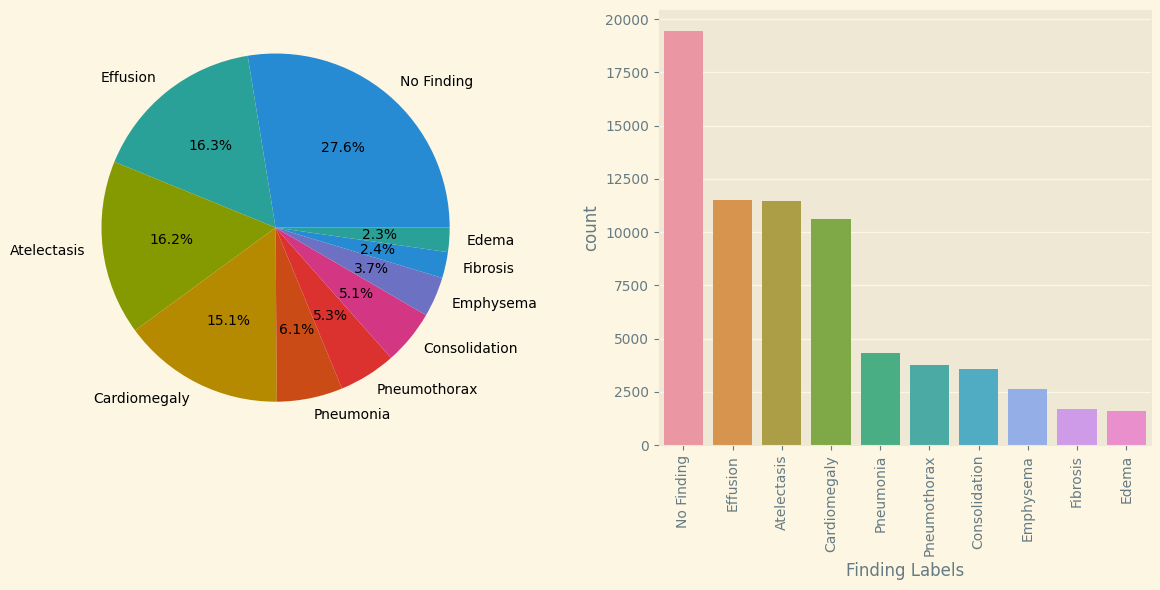

In [9]:
label_counts = df['Finding Labels'].str.split('|').explode().value_counts()

plt.style.use('Solarize_Light2')

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.pie(df['Finding Labels'].str.split('|').explode().value_counts(), labels=label_counts.index, autopct='%.1f%%')
# plt.legend()
plt.subplot(1,2,2)
sns.countplot(x=df['Finding Labels'].str.split('|').explode(), order= label_counts.index)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


**Train & Test Split**

In [10]:
df_train, df_test = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

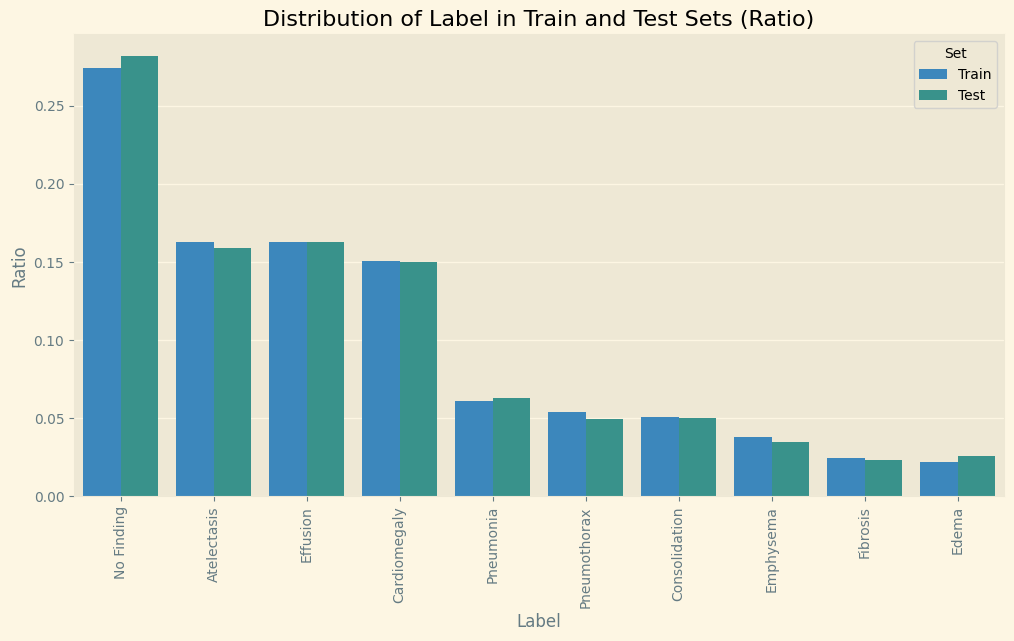

In [11]:
# Train and Test labels
train_labels = df_train['Finding Labels'].str.split('|').explode().value_counts(normalize=True)
test_labels = df_test['Finding Labels'].str.split('|').explode().value_counts(normalize=True)

# Combine into one DataFrame for plotting
combined_df = pd.DataFrame({
    'Label': train_labels.index,
    'Train': train_labels.values,
    'Test': test_labels.reindex(train_labels.index, fill_value=0).values
})

# Melt the DataFrame to make it long-form for Seaborn plotting
combined_df_melt = combined_df.melt(id_vars='Label', var_name='Set', value_name='Ratio')

# Plot
plt.figure(figsize=(12, 6))
plt.title('Distribution of Label in Train and Test Sets (Ratio)')
sns.barplot(x='Label', y='Ratio', hue='Set', data=combined_df_melt)

plt.ylabel('Ratio')
plt.xticks(rotation=90)
plt.show()


**One Hot Encoding**

In [12]:
allowed_labels = ['No Finding', 'Cardiomegaly', 'Edema', 'Atelectasis', 'Pneumonia',
                  'Effusion', 'Pneumothorax', 'Emphysema', 'Consolidation', 'Fibrosis']

for label in allowed_labels:
    df_test[label] = df_test['Finding Labels'].apply(lambda x: 1.0 if label in x.split('|') else 0.0).astype('float32')
    df_train[label] = df_train['Finding Labels'].apply(lambda x: 1.0 if label in x.split('|') else 0.0).astype('float32')

TARGET = allowed_labels

In [13]:
TARGET

['No Finding',
 'Cardiomegaly',
 'Edema',
 'Atelectasis',
 'Pneumonia',
 'Effusion',
 'Pneumothorax',
 'Emphysema',
 'Consolidation',
 'Fibrosis']

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>3. Build Mask Generator</b></div>

In [14]:
!pip install -q torch_geometric==2.3.0
!git clone -q https://github.com/ngaggion/CheXmask-Database.git
sys.path.append('/kaggle/working/CheXmask-Database/HybridGNet')

In [15]:
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.conv.cheb_conv import ChebConv
from torch_geometric.nn.inits import zeros, normal
import torchvision.ops.roi_align as roi_align

## HybridGNet
from utils.utils import scipy_to_torch_sparse, mOrgan, mOrganD, mOrganU, genMatrixesLungsHeart
from models.modelUtils import ChebConv, Pool, residualBlock
from models.HybridGNet2IGSC import EncoderConv, SkipBlock

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [17]:
def getDenseMask(landmarks, h, w):
    RL = landmarks[0:44]
    LL = landmarks[44:94]
    H = landmarks[94:]
    
    img = np.zeros([h, w], dtype = 'uint8')
    
    RL = RL.reshape(-1, 1, 2).astype('int')
    LL = LL.reshape(-1, 1, 2).astype('int')
    H = H.reshape(-1, 1, 2).astype('int')

    img = cv2.drawContours(img, [RL], -1, 255, -1)
    img = cv2.drawContours(img, [LL], -1, 255, -1)
    img = cv2.drawContours(img, [H], -1, 255, -1)
    
    return img

class Hybrid(nn.Module):
    def __init__(self, config, downsample_matrices, upsample_matrices, adjacency_matrices):
        super(Hybrid, self).__init__()
        
        self.config = config
        hw = config['inputsize'] // 32
        self.z = config['latents']
        self.encoder = EncoderConv(latents = self.z, hw = hw)
        
        self.downsample_matrices = downsample_matrices
        self.upsample_matrices = upsample_matrices
        self.adjacency_matrices = adjacency_matrices
        self.kld_weight = 1e-5
                
        n_nodes = config['n_nodes']
        self.filters = config['filters']
        self.K = 6
        self.window = (3,3)
        
        # Genero la capa fully connected del decoder
        outshape = self.filters[-1] * n_nodes[-1]          
        self.dec_lin = torch.nn.Linear(self.z, outshape)
                
        self.normalization2u = torch.nn.InstanceNorm1d(self.filters[1])
        self.normalization3u = torch.nn.InstanceNorm1d(self.filters[2])
        self.normalization4u = torch.nn.InstanceNorm1d(self.filters[3])
        self.normalization5u = torch.nn.InstanceNorm1d(self.filters[4])
        self.normalization6u = torch.nn.InstanceNorm1d(self.filters[5])
        
        outsize1 = self.encoder.size[4]
        outsize2 = self.encoder.size[4]  
                     
        # Guardo las capas de convoluciones en grafo
        self.graphConv_up6 = ChebConv(self.filters[6], self.filters[5], self.K)
        self.graphConv_up5 = ChebConv(self.filters[5], self.filters[4], self.K)       
        
        self.SC_1 = SkipBlock(self.filters[4], self.window)
        
        self.graphConv_up4 = ChebConv(self.filters[4] + outsize1 + 2, self.filters[3], self.K)        
        self.graphConv_up3 = ChebConv(self.filters[3], self.filters[2], self.K)
        
        self.SC_2 = SkipBlock(self.filters[2], self.window)
        
        self.graphConv_up2 = ChebConv(self.filters[2] + outsize2 + 2, self.filters[1], self.K)
        self.graphConv_up1 = ChebConv(self.filters[1], self.filters[0], 1, bias = False)
                
        self.pool = Pool()
        
        self.reset_parameters()
        
    def reset_parameters(self):
        torch.nn.init.normal_(self.dec_lin.weight, 0, 0.1)


    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) 
    
        
    def forward(self, x):
        self.mu, self.log_var, conv6, conv5 = self.encoder(x)

        if self.training:
            z = self.sampling(self.mu, self.log_var)
        else:
            z = self.mu
            
        x = self.dec_lin(z)
        x = F.relu(x)
        
        x = x.reshape(x.shape[0], -1, self.filters[-1])
        
        x = self.graphConv_up6(x, self.adjacency_matrices[5]._indices())
        x = self.normalization6u(x)
        x = F.relu(x)
        
        x = self.graphConv_up5(x, self.adjacency_matrices[4]._indices())
        x = self.normalization5u(x)
        x = F.relu(x)
        
        x, pos1 = self.SC_1(x, self.adjacency_matrices[3]._indices(), conv6)
        
        x = self.graphConv_up4(x, self.adjacency_matrices[3]._indices())
        x = self.normalization4u(x)
        x = F.relu(x)
        
        x = self.pool(x, self.upsample_matrices[0])
        
        x = self.graphConv_up3(x, self.adjacency_matrices[2]._indices())
        x = self.normalization3u(x)
        x = F.relu(x)
        
        x, pos2 = self.SC_2(x, self.adjacency_matrices[1]._indices(), conv5)
        
        x = self.graphConv_up2(x, self.adjacency_matrices[1]._indices())
        x = self.normalization2u(x)
        x = F.relu(x)
        
        x = self.graphConv_up1(x, self.adjacency_matrices[0]._indices()) # Sin relu y sin bias
        
        return x

def loadModel(device):    
    A, AD, D, U = genMatrixesLungsHeart()
    N1 = A.shape[0]
    N2 = AD.shape[0]

    A = sp.csc_matrix(A).tocoo()
    AD = sp.csc_matrix(AD).tocoo()
    D = sp.csc_matrix(D).tocoo()
    U = sp.csc_matrix(U).tocoo()

    D_ = [D.copy()]
    U_ = [U.copy()]

    config = {}

    config['n_nodes'] = [N1, N1, N1, N2, N2, N2]
    A_ = [A.copy(), A.copy(), A.copy(), AD.copy(), AD.copy(), AD.copy()]
    
    A_t, D_t, U_t = ([scipy_to_torch_sparse(x).to(device) for x in X] for X in (A_, D_, U_))

    config['latents'] = 64
    config['inputsize'] = 1024

    f = 32
    config['filters'] = [2, f, f, f, f//2, f//2, f//2]
    config['skip_features'] = f

    hybrid = Hybrid(config.copy(), D_t, U_t, A_t).to(device)
    hybrid.load_state_dict(torch.load('/kaggle/input/chexmask/SegmentationModel/bestMSE.pt', map_location=torch.device(device)))
    hybrid.eval()
    
    return hybrid

In [18]:
class MaskGenerator(torch.utils.data.Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        row = self.data.iloc[index]
        path = row['path']
            
        if np.array(Image.open(path)).dtype == np.uint16:
            img = np.array(Image.open(path))
            img = (img / 65536.0 * 255).astype(np.uint8)
            img = Image.fromarray(img)
            img = img.resize((1024, 1024), Image.Resampling.LANCZOS)
            img = np.array(img)
            img = img.astype(np.uint8)
            img = img/255
            
        else: 
            img = Image.open(path).convert('L')
            img = img.resize((1024, 1024), Image.Resampling.LANCZOS)
            img = np.array(img) 
            img = img / 255
            
        # FillNaN
        m = np.nanmean(img)
        img = np.nan_to_num(img, nan=m)
        
        img = torch.from_numpy(img).unsqueeze(0).to(device).float()
            
        return img

In [19]:
dataset = MaskGenerator(df)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)

In [20]:
Load_Mask = False

In [21]:
%%time

if Load_Mask: 
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  
    hybrid = loadModel(device)

    all_mask = []

    with torch.no_grad():
      
        for batch in tqdm(dataloader):
            batch = batch.to(device)

            output = hybrid(batch)
        
            for i in range(output.size(0)):
                mask = output[i].cpu().numpy().reshape(-1,2)
    
                mask = mask * 256
                mask = mask.astype('int')
            
                mask = getDenseMask(mask, 256, 256)
                all_mask.append(mask)
else: 
     tmp = {os.path.basename(x).replace('_mask', ''): x for x in glob(os.path.join('/kaggle', 'input', '*','cxr-mask','*','*'))}
     df_train['mask_path'] = df_train['Image Index'].map(tmp)
     df_test['mask_path'] = df_test['Image Index'].map(tmp)

CPU times: user 328 ms, sys: 51.4 ms, total: 379 ms
Wall time: 1.43 s


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>4. Build DataGenerator</b></div>

In [22]:
import albumentations as albu
print(albu.__version__)

1.4.17


In [23]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=16, shuffle=False, augment1=False, augment2=False, preprocess=None):
        super().__init__()
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment1 = augment1
        self.augment2 = augment2
        self.on_epoch_end()
        self.preprocess = preprocess
        self.clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        
    def __len__(self):
        
        # Drop_Last = False
        ct = int(np.ceil(len(self.data)/self.batch_size))
        return ct
    
    def __getitem__(self,index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.preprocess != None: X = self.preprocess(X)
        if self.augment1: X = self.__augment1(X)
        if self.augment2: X = self.__augment2(X)
        return X,y
    
    def on_epoch_end(self,):
        self.indexes = np.arange(len(self.data))
        if self.shuffle: np.random.shuffle(self.indexes)

    def __crop_lung_mask(self, xray_image, lung_mask):
        cnts, _ = cv2.findContours(lung_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  
        if len(cnts) == 0:
            print("No contours found in the lung mask.")
            return xray_image, lung_mask

        elif len(cnts) == 1:
            contour = cnts[0]

        elif len(cnts) >= 2:
            c0 = cnts[0]
            c1 = cnts[1]

            contour = np.vstack((c0,c1))

        x, y, w, h = cv2.boundingRect(contour)
        
        cropped_image = xray_image[y:y+h, x:x+w]
        
        return cropped_image
        
    def __data_generation(self, indexes):
        
        X = np.zeros((len(indexes),256,256,3), dtype='float32') 
        y = np.zeros((len(indexes),len(TARGET)), dtype='float32')
        
        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            path = row['path']
            mask_path = row['mask_path']
            
            if np.array(Image.open(path)).dtype == np.uint16:
                img = np.array(Image.open(path))
                img = (img / 65536.0 * 255).astype(np.uint8)
                img = Image.fromarray(img)
                img = img.resize((256, 256), Image.Resampling.LANCZOS)
                img = np.array(img)
                img = img.astype(np.uint8)
                img = self.clahe.apply(img)
                img = np.expand_dims(img, axis=-1)
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            else: 
                img = Image.open(path).convert('L')
                img = img.resize((256,256), Image.Resampling.LANCZOS)
                img = np.array(img) 
                img = self.clahe.apply(img)
                img = np.expand_dims(img, axis=-1)  
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) 
                
            # FillNaN
            m = np.nanmean(img)
            img = np.nan_to_num(img, nan=m)

            #Mask
            mask = Image.open(mask_path)
            mask = np.array(mask)
            
            cropped_img = self.__crop_lung_mask(img, mask)
            cropped_img = cv2.resize(cropped_img, (256, 256))

            X[j,:,:,:3] = cropped_img
            y[j,] = row[TARGET]
            
        return X,y
            
    
    def __augment1(self, img_batch):
        
        composition = albu.Compose([
                 albu.OneOf([albu.HorizontalFlip(p=1.0)], p=0.5),
                 albu.OneOf([albu.Rotate(limit=5, p=1.0)], p=0.5),
        ])
        
        for i in range(img_batch.shape[0]):
            img = composition(image=img_batch[i,])['image']
            img_batch[i,] = img
            
        return img_batch
    
    
    def __augment2(self, img_batch,cutmix_prob=0.5, num_patches=2):
        batch_size, height, width, channels = img_batch.shape

        for i in range(batch_size):
            if np.random.rand() <= cutmix_prob:  
                for _ in range(num_patches):  # 여러 개의 패치를 적용하기 위해 반복문 추가
                    idx = np.random.randint(batch_size)
                    lam = np.random.beta(2.0, 2.0)
         
                    cut_width = min(int(width * lam), width//5)
                    cut_height = min(int(height * lam), height//5)
                    cut_x = np.random.randint(0, width - cut_width + 1)
                    cut_y = np.random.randint(0, height - cut_height + 1)

                    img_batch[i, cut_y:cut_y + cut_height, cut_x:cut_x + cut_width, :] = img_batch[idx, cut_y:cut_y + cut_height, cut_x:cut_x + cut_width, :]
            
        return img_batch

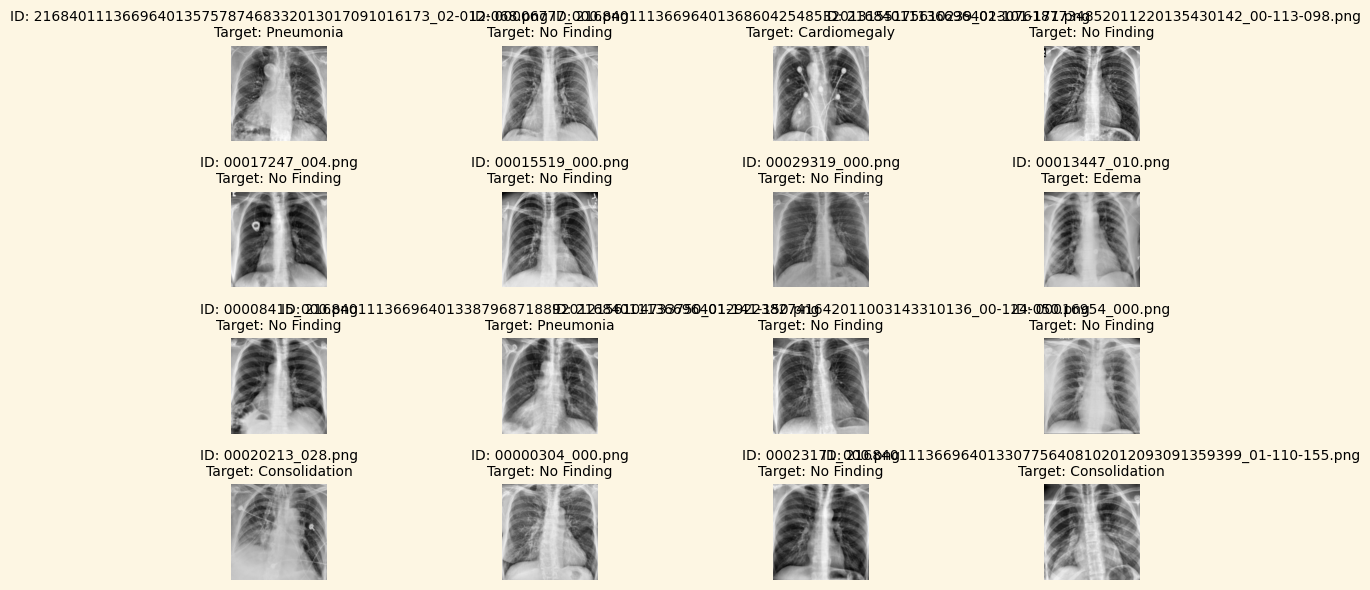

In [24]:
ROWS = 4; COLS = 4; BATCHES = 1


gen = DataGenerator(df_train,batch_size=16, shuffle=False, augment1=True, augment2=False, preprocess=None)

for i, (x,y) in enumerate(gen):
    plt.figure(figsize=(12,6))
    for j in range(ROWS):
        for k in range(COLS):
            plt.subplot(ROWS, COLS, j*COLS+k+1)
            img_id = df_train.iloc[i*16+j*COLS+k]['Image Index']
            plt.title(f'ID: {img_id}\nTarget: {df_train.iloc[i*16+j*COLS+k]["Finding Labels"]}', size=10)
            img = x[j*COLS+k,:,:,:3]
            img = img.astype('uint8')
            plt.imshow(img)
            plt.axis('off')
    plt.tight_layout()
    plt.show()
    if i==BATCHES-1: break

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>5. Build EfficientNet Model</b></div>

**Install efficientnet**

In [25]:
!pip install -q -U git+https://github.com/qubvel/efficientnet
    
import efficientnet.tfkeras as efn

**Install Tfimm**

In [26]:
!pip install -q tfimm

import tfimm

**Channel Attention**

In [27]:

class CAM(layers.Layer):
    def __init__(self, ratio=8):
        super().__init__()
        self.ratio = ratio
        self.gap = layers.GlobalAveragePooling2D()
        self.gmp = layers.GlobalMaxPooling2D()

    def build(self, input_shape):
        self.conv1 = layers.Conv2D(input_shape[-1]//self.ratio,
                                   kernel_size=1,
                                   strides=1, padding='same',
                                   activation='relu')
        self.conv2 = layers.Conv2D(input_shape[-1],
                                   kernel_size=1,
                                   strides=1, padding='same',
                                   activation='relu')

    def call(self, inputs):
        gap = self.gap(inputs)
        gmp = self.gmp(inputs)
        gap = layers.Reshape((1,1,gap.shape[1]))(gap)
        gmp = layers.Reshape((1,1,gmp.shape[1]))(gmp)
        gap_out = self.conv2(self.conv1(gap))
        gmp_out = self.conv2(self.conv1(gmp))

        return tf.math.sigmoid(gap_out+gmp_out)

In [28]:
def build_model():
    inp = layers.Input(shape=(256,256,3))
    eff_model = efn.EfficientNetB0(include_top=False, weights=None, input_shape=(256,256,3))
    eff_model.load_weights('/kaggle/input/tf-efficientnet-noisy-student-weights/efficientnet-b0_noisy-student_notop.h5')
    cait_model = tfimm.create_model('cait_s24_224', in_channels=3, nb_classes=0, pretrained=True, 
                                     input_size=(256,256))
    
    eff_out = eff_model(inp)
    eff_out = CAM()(eff_out) * eff_out
    eff_out = layers.GlobalAveragePooling2D()(eff_out)
    
    
    cait_out = cait_model(inp)
    cait_out = layers.RepeatVector(5)(cait_out)
    
    cait_out = layers.Bidirectional(
               layers.LSTM(cait_out.shape[-1]//2, return_sequences=False)
    )(cait_out)
    
    out = layers.Concatenate(axis=-1)([eff_out, cait_out])
    
    x = layers.Dense(len(TARGET), activation='sigmoid', dtype='float32')(out)
    
    # Compile
    model = Model(inputs=inp, outputs=x, name='Hybrid')
    loss = losses.BinaryCrossentropy(label_smoothing=0.05)
    opt = optimizers.Adam(learning_rate=1e-3)
    label_weights = [1.0] * len(TARGET)
    AUC = tf.keras.metrics.AUC(name='auc', label_weights=label_weights)
    
    model.compile(loss=loss, optimizer=opt, metrics=[AUC])
    
    return model

In [29]:
from tensorflow.keras.utils import plot_model
K.clear_session()
model = build_model()
model.summary()

#plot_model(model, show_shapes=True, show_layer_names=True)

model.safetensors:   0%|          | 0.00/188M [00:00<?, ?B/s]

Model: "Hybrid"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 efficientnet-b0 (Functiona  (None, 8, 8, 1280)           4049564   ['input_1[0][0]']             
 l)                                                                                               
                                                                                                  
 cam (CAM)                   (None, 1, 1, 1280)           411040    ['efficientnet-b0[0][0]']     
                                                                                                  
 cait_s24_224 (CaiT)         (None, 384)                  4655424   ['input_1[0][0]']        

In [30]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping 

EPOCHS = 10

es = EarlyStopping(monitor='val_auc', mode='max', patience=5)
lr = ReduceLROnPlateau(monitor = 'val_auc', factor = 0.1, patience = 1, min_delta = 0.01,
                              mode='max',verbose=1)

# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>6. Train CNN Model</b></div>

In [31]:
gkf = GroupKFold(n_splits=5)
for i, (_, valid_index) in enumerate(gkf.split(df_train, groups=df_train['Patient ID'])):
    df_train.loc[valid_index, 'Fold'] = i

In [32]:
import tensorflow.keras.backend as K

all_oof = []
all_true = []
all_index = []
all_history = defaultdict(list)

for i in range(1):
    
    print('#'*25)
    print(f'### Fold {i+1}')
    
    train_gen = DataGenerator(df_train[df_train['Fold'] != i], shuffle=True, augment1=True, augment2=True, batch_size=32, preprocess=efn.preprocess_input)
    valid_gen = DataGenerator(df_train[df_train['Fold'] == i], shuffle=False, batch_size=64, preprocess=efn.preprocess_input)
    
    print(f'### train size {len(df_train[df_train["Fold"] != i])}, valid size {len(df_train[df_train["Fold"] == i])}')
    print('#'*25)
    
    K.clear_session()
    with strategy.scope():
        model = build_model()
    if LOAD_MODELS_FROM is None:
        history =  model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [lr])
        model.save_weights(f'Hybrid_f{i}.weights.h5')
        all_history['Train Loss'].append(history.history['loss'])
        all_history['Valid Loss'].append(history.history['val_loss'])
        all_history['Valid Auc'].append(history.history['val_auc'])
        all_history['Train Auc'].append(history.history['auc'])

    else:
        model.load_weights(f'{LOAD_MODELS_FROM}Hybrid_f{i}.weights.h5')
        
    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(df_train[df_train['Fold'] == i][TARGET].values)
    all_index.append(df_train[df_train['Fold'] == i]['Image Index'].values)
    
    
    del model, oof, train_gen, valid_gen
    gc.collect()
    
all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)
all_index = np.concatenate(all_index)

#########################
### Fold 1
### train size 38220, valid size 9555
#########################
Epoch 1/10


I0000 00:00:1729302884.366157      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1195/1195 [==============================] - 2317s 2s/step - loss: 0.3072 - auc: 0.8690 - val_loss: 0.5314 - val_auc: 0.4560 - lr: 0.0010
Epoch 2/10
1195/1195 [==============================] - ETA: 0s - loss: 0.2978 - auc: 0.8823
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
1195/1195 [==============================] - 1655s 1s/step - loss: 0.2978 - auc: 0.8823 - val_loss: 1.8004 - val_auc: 0.3813 - lr: 0.0010
Epoch 3/10
1195/1195 [==============================] - 1745s 1s/step - loss: 0.2842 - auc: 0.9018 - val_loss: 0.2930 - val_auc: 0.8911 - lr: 1.0000e-04
Epoch 4/10
1195/1195 [==============================] - 1671s 1s/step - loss: 0.2807 - auc: 0.9068 - val_loss: 0.2776 - val_auc: 0.9121 - lr: 1.0000e-04
Epoch 5/10
1195/1195 [==============================] - ETA: 0s - loss: 0.2791 - auc: 0.9084
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
1195/1195 [==============================] - 1989s 2s/step - loss: 0.2791 - au

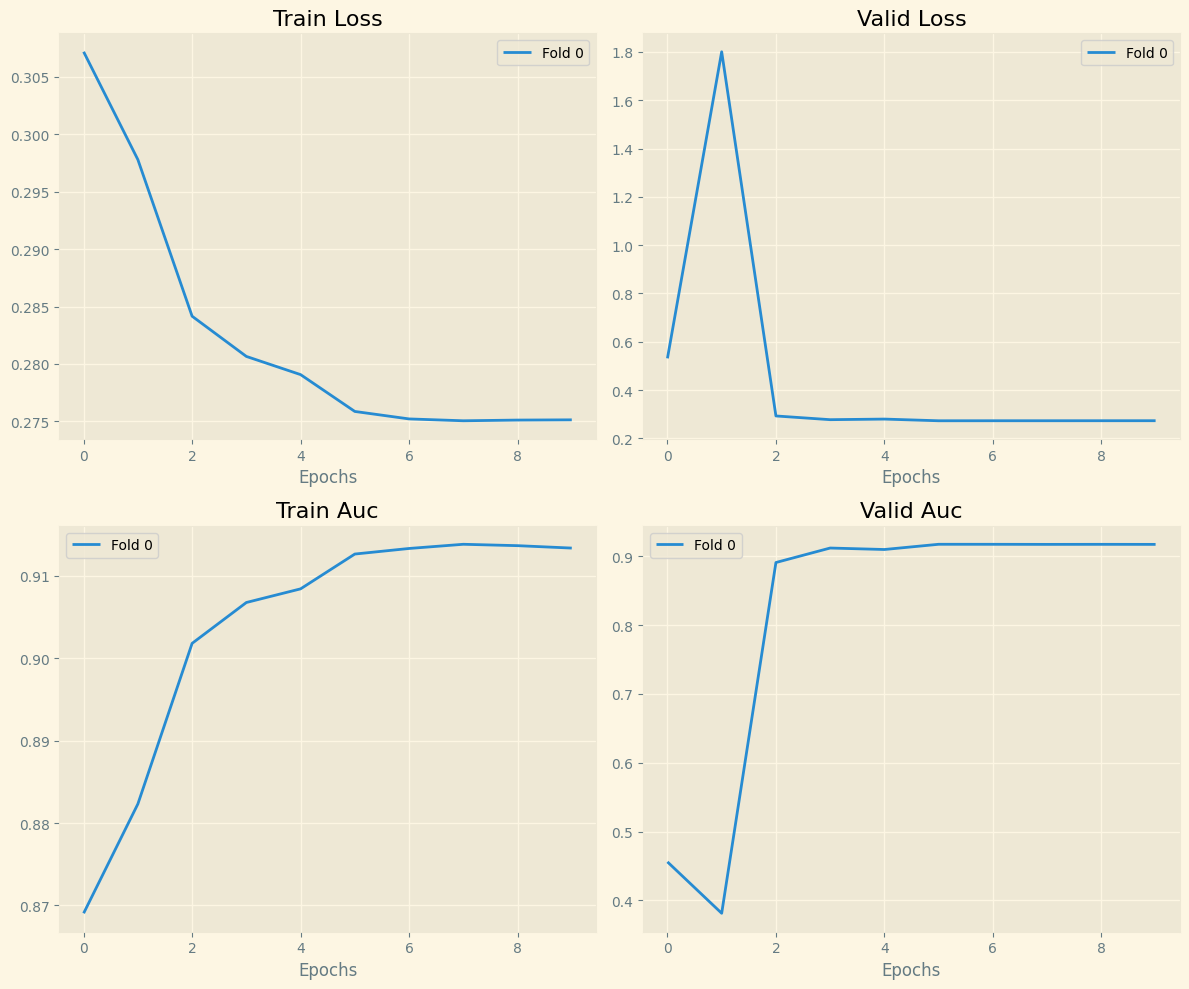

In [33]:
if LOAD_MODELS_FROM is None:
    plt.figure(figsize=(12,10))
    plt.subplot(2,2,1)
    plt.title('Train Loss')
    for fold, i in enumerate(all_history['Train Loss']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,2,2)
    plt.title('Valid Loss')
    for fold, i in enumerate(all_history['Valid Loss']):
        plt.plot(i,label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(2,2,3)
    plt.title('Train Auc')
    for fold, i in enumerate(all_history['Train Auc']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()
    
    plt.subplot(2,2,4)
    plt.title('Valid Auc')
    for fold, i in enumerate(all_history['Valid Auc']):
        plt.plot(i, label=f'Fold {fold}')
        plt.xlabel('Epochs')
    plt.legend()


    
    plt.tight_layout()
    plt.show()

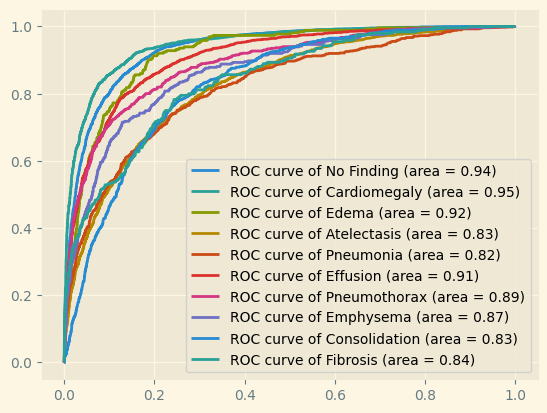

In [34]:
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(all_true[:, i], all_oof[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()


In [35]:
auc_score = roc_auc_score(all_true, all_oof, average='macro', multi_class='ovr')  # 'ovr'은 one-vs-rest 방식
print('AUC for Train Set =', auc_score)

AUC for Train Set = 0.878554125481983


# <div style="padding: 25px;color:white;margin:10;font-size:60%;text-align:left;display:fill;border-radius:10px;background-color:#FFFFFF;overflow:hidden;background-color:#A51C30"><b><span style='color:#A51C30'></span></b> <b>7. Inference</b></div>

In [36]:
preds = []
model = build_model()

## No TTA
test_gen = DataGenerator(df_test, shuffle=False, batch_size=128, augment1=True, preprocess=efn.preprocess_input)

for i in range(1):
    print(f'Fold {i+1}') 
    K.clear_session()
    if LOAD_MODELS_FROM:
        model.load_weights(f'{LOAD_MODELS_FROM}Hybrid_f{i}.weights.h5')
    else: 
        model.load_weights(f'Hybrid_f{i}.weights.h5')
    
    pred = model.predict(test_gen, verbose=1) 
    
preds.append(pred)
pred_res = np.mean(preds,axis=0)
    

auc_score = roc_auc_score(df_test[TARGET], pred_res, average='macro', multi_class='ovr')  # 'ovr'은 one-vs-rest 방식
print('AUC for Test Set =', auc_score)

Fold 1
94/94 [==============================] - 642s 7s/step
AUC for Test Set = 0.8851771637683635


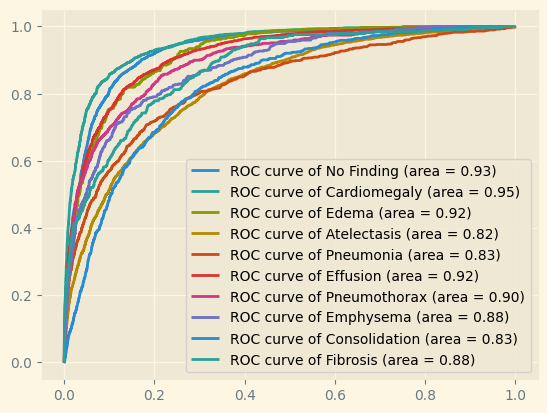

In [37]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(TARGET)):
    fpr[i], tpr[i], _ = roc_curve(df_test[TARGET[i]], pred_res[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# ROC 곡선 그리기
plt.figure()
for i in range(len(TARGET)):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of {TARGET[i]} (area = {roc_auc[i]:0.2f})')
plt.legend()
plt.show()